# 📚 Student Setup Instructions - News Sentiment Analysis Agent

## 🎯 What This Notebook Does
This notebook teaches you how to build an AI agent using **LangGraph** that:
1. **Retrieves REAL news articles** from NewsAPI.org (80,000+ sources worldwide!)
2. **Analyzes sentiment** using **local transformer models** (DistilBERT)
3. **Visualizes workflows** as interactive graphs
4. **Returns actual URLs** to real news websites

---

## ⚙️ Prerequisites & Setup

### Step 1: Install Python Dependencies

Make sure you have these packages installed:

```bash
pip install langgraph langchain-core transformers torch requests matplotlib pandas
```

### Step 2: Get FREE NewsAPI Key (2 minutes)

🔑 **To fetch REAL news articles**, you need a free API key:

1. Visit: **https://newsapi.org/register**
2. Sign up with your email (free!)
3. Copy your API key
4. Paste it in **Cell 10** where it says `NEWS_API_KEY = None`

**Free Tier**: 100 requests/day, 80,000+ news sources, real-time articles

### Step 3: Verify Setup

Run Cell 2 to check if everything is installed correctly.

---

## ✅ What You'll Learn

1. **Build a multi-step AI workflow** with LangGraph
2. **Fetch real news** from NewsAPI.org API
3. **Use local AI models** (transformers) for sentiment analysis
4. **Create stateful agents** that maintain context across steps
5. **Visualize agent workflows** as graphs
6. **Integrate multiple APIs** in a single workflow

---

## 📝 Key Features

- ✅ **REAL News**: Fetches actual articles from 80,000+ sources
- ✅ **Actual URLs**: Get direct links to the original articles
- ✅ **Local AI**: Sentiment analysis runs on your machine (private!)
- ✅ **Free**: NewsAPI free tier + free local models
- ✅ **Fast**: Processes multiple articles in seconds

---

In [ ]:
# ========================================
# VERIFICATION CELL - Run this first!
# ========================================
# This cell checks if all required packages are installed

print("🔍 Checking required packages...\n")

required_packages = {
    'langgraph': 'LangGraph',
    'langchain_core': 'LangChain Core',
    'transformers': 'Hugging Face Transformers',
    'torch': 'PyTorch',
    'requests': 'Requests',
    'matplotlib': 'Matplotlib'
}

missing_packages = []
installed_packages = []

for package, name in required_packages.items():
    try:
        __import__(package)
        installed_packages.append(name)
        print(f"✅ {name} - Installed")
    except ImportError:
        missing_packages.append(package)
        print(f"❌ {name} - NOT installed")

print("\n" + "="*50)

if not missing_packages:
    print("✅ SUCCESS! All packages are installed!")
    print("="*50)
    print("\n🎉 You're ready to run this notebook!")
    print("\n💡 Tips:")
    print("   - The first run will download sentiment models (~268MB)")
    print("   - You'll need a News API key (free at newsapi.org)")
    print("   - Run cells sequentially for best results\n")
else:
    print("❌ Missing Packages!")
    print("="*50)
    print(f"\n📥 To install missing packages, run:")
    print(f"   pip install {' '.join(missing_packages)}")
    print("\n🔄 Then re-run this cell.\n")

In [ ]:
# ========================================
# LangGraph Tutorial: News Sentiment Analysis Workflow
# Using LOCAL AI Models - No API Keys for Sentiment Analysis!
# ========================================

"""
This notebook demonstrates how to build an AI agent using **LangGraph** that:
1. Retrieves news articles based on a topic, time interval, and location
2. Analyzes sentiment using **local transformer models** (Hugging Face)
3. Visualizes the workflow graph

## What is LangGraph?

LangGraph is a library for building stateful, multi-actor applications with LLMs. 
It extends LangChain with the ability to create cyclical graphs, which are essential 
for agent-like behaviors.

Key concepts:
- **Nodes**: Functions that perform actions (e.g., fetch news, analyze sentiment)
- **Edges**: Connect nodes to define workflow
- **State**: Shared data structure passed between nodes
- **Conditional Edges**: Dynamic routing based on state

## Why Use Local Models?

✅ **Privacy**: All sentiment analysis happens on your machine
✅ **Cost**: No per-request charges for sentiment analysis
✅ **Speed**: No network latency for AI inference
✅ **Learning**: Understand how transformer models work locally
"""

print("📖 Notebook loaded!")
print("🚀 Ready to build a news sentiment analysis agent with LOCAL AI models!")

## 1. Install Required Packages

First, let's ensure we have all necessary packages installed.

In [1]:
# ========================================
# IMPORT LIBRARIES
# ========================================

# Standard library imports
import os
from typing import TypedDict, Annotated, Sequence
from datetime import datetime, timedelta
import operator
from IPython.display import Image, display
import requests

# LangGraph and LangChain - for building the agent workflow
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage

# Transformers - LOCAL AI models for sentiment analysis (no API needed!)
from transformers import pipeline

# Visualization
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✅ All imports successful!")
print("📝 Using LOCAL transformer models for sentiment analysis")

✅ All imports successful!
📝 Using LOCAL transformer models for sentiment analysis


## 2. Define the State

In LangGraph, the **State** is a shared data structure that flows through the graph. Each node can read from and write to the state.

In [2]:
class AgentState(TypedDict):
    """State object that flows through the graph"""
    topic: str  # News topic to search for
    location: str  # Geographic location/state
    time_interval: int  # Days to look back
    news_articles: list  # Retrieved articles
    sentiment_results: list  # Sentiment analysis results
    messages: Annotated[Sequence[BaseMessage], operator.add]  # Conversation history
    
print("✅ State definition created!")
print("\nState fields:")
print("  - topic: News topic to search")
print("  - location: Geographic location")
print("  - time_interval: Days to look back")
print("  - news_articles: Retrieved articles")
print("  - sentiment_results: Sentiment analysis")
print("  - messages: Conversation history")

✅ State definition created!

State fields:
  - topic: News topic to search
  - location: Geographic location
  - time_interval: Days to look back
  - news_articles: Retrieved articles
  - sentiment_results: Sentiment analysis
  - messages: Conversation history


## 3. Create Tools - News Retrieval

We'll use **NewsAPI** (free tier available) to fetch news articles. For this tutorial, we'll also create a fallback mock tool if you don't have an API key yet.

## 🔑 IMPORTANT: Get Your FREE API Key

To fetch **REAL news articles** with actual URLs, you need a free API key from NewsAPI.org:

### Quick Setup (2 minutes):

1. **Visit**: https://newsapi.org/register
2. **Sign up** with your email (it's free!)
3. **Copy your API key** from the dashboard
4. **Paste it** in the cell below where it says `NEWS_API_KEY = None`

### Example:
```python
NEWS_API_KEY = "1234567890abcdef1234567890abcdef"  # Your actual key
```

### Free Tier Includes:
- ✅ 100 requests per day
- ✅ Access to 80,000+ news sources worldwide
- ✅ Real-time news articles
- ✅ Actual URLs to the news websites

**Note**: Without an API key, the notebook will use mock/demo data for teaching purposes.

In [ ]:
def fetch_real_news(topic: str, location: str, days_back: int, api_key: str = None) -> list:
    """
    Fetch REAL news from NewsAPI.org
    
    🔑 Get your FREE API key:
    1. Go to https://newsapi.org/register
    2. Sign up (free tier: 100 requests/day)
    3. Copy your API key
    4. Paste it when calling this function OR set it as environment variable
    
    Args:
        topic: Search term (e.g., "artificial intelligence")
        location: Not used by NewsAPI (uses 'country' instead)
        days_back: How many days to look back
        api_key: Your NewsAPI key (or set NEWS_API_KEY environment variable)
    """
    try:
        # Check for API key
        if not api_key:
            api_key = os.environ.get('NEWS_API_KEY')
        
        if not api_key:
            print("❌ No API key provided!")
            print("📝 To get real news, you need a FREE API key from https://newsapi.org/")
            print("💡 Quick steps:")
            print("   1. Visit: https://newsapi.org/register")
            print("   2. Sign up (takes 30 seconds)")
            print("   3. Get your API key")
            print("   4. Add it to the function call or set NEWS_API_KEY environment variable")
            print("\n⚠️  Falling back to mock data for now...\n")
            return _get_mock_data(topic, location, days_back)
        
        # NewsAPI endpoint
        url = "https://newsapi.org/v2/everything"
        
        # Calculate date range
        to_date = datetime.now()
        from_date = to_date - timedelta(days=days_back)
        
        params = {
            'q': topic,
            'from': from_date.strftime('%Y-%m-%d'),
            'to': to_date.strftime('%Y-%m-%d'),
            'sortBy': 'publishedAt',
            'language': 'en',
            'apiKey': api_key,
            'pageSize': 10  # Get up to 10 articles
        }
        
        print(f"🔍 Fetching REAL news about '{topic}' from NewsAPI...")
        print(f"📅 Date range: {from_date.strftime('%Y-%m-%d')} to {to_date.strftime('%Y-%m-%d')}")
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            articles = data.get('articles', [])
            
            if not articles:
                print(f"⚠️  No articles found for '{topic}'")
                return []
            
            # Format articles to match our structure
            formatted_articles = []
            for article in articles:
                formatted_articles.append({
                    'title': article.get('title', 'No title'),
                    'description': article.get('description', 'No description'),
                    'pubDate': article.get('publishedAt', 'Unknown'),
                    'source_id': article.get('source', {}).get('name', 'Unknown'),
                    'link': article.get('url', 'No URL'),  # REAL URL!
                    'author': article.get('author', 'Unknown'),
                    'urlToImage': article.get('urlToImage', '')
                })
            
            print(f"✅ Found {len(formatted_articles)} REAL articles from actual news sources!")
            return formatted_articles
            
        elif response.status_code == 401:
            print(f"❌ Invalid API key!")
            print("💡 Make sure you copied your API key correctly from https://newsapi.org/")
            return _get_mock_data(topic, location, days_back)
        elif response.status_code == 426:
            print(f"❌ API key error: You might need to upgrade your plan")
            return _get_mock_data(topic, location, days_back)
        else:
            print(f"❌ Error: HTTP {response.status_code}")
            return _get_mock_data(topic, location, days_back)
            
    except Exception as e:
        print(f"❌ Error fetching news: {e}")
        return _get_mock_data(topic, location, days_back)


def _get_mock_data(topic: str, location: str, days_back: int) -> list:
    """Fallback mock data if API is not available"""
    print("📋 Using mock data (for demonstration)")
    mock_articles = [
        {
            'title': f'{topic.title()} Innovation Breakthrough Announced',
            'description': f'Major developments in {topic} technology are revolutionizing the industry.',
            'pubDate': (datetime.now() - timedelta(days=1)).isoformat(),
            'source_id': 'Tech News',
            'link': f'https://example.com/news/{topic.replace(" ", "-")}-innovation',
            'author': 'Demo Author',
            'urlToImage': ''
        },
        {
            'title': f'{topic.title()} Conference Attracts Industry Leaders',
            'description': f'Experts gathered to discuss the future of {topic} and its impact.',
            'pubDate': (datetime.now() - timedelta(days=2)).isoformat(),
            'source_id': 'Business Insider',
            'link': f'https://example.com/news/{topic.replace(" ", "-")}-conference',
            'author': 'Demo Author',
            'urlToImage': ''
        },
        {
            'title': f'{topic.title()} Market Shows Strong Growth',
            'description': f'Analysts remain optimistic about {topic} prospects for the coming year.',
            'pubDate': (datetime.now() - timedelta(days=3)).isoformat(),
            'source_id': 'Market Watch',
            'link': f'https://example.com/news/{topic.replace(" ", "-")}-market',
            'author': 'Demo Author',
            'urlToImage': ''
        }
    ]
    return mock_articles


# 🔑 SET YOUR API KEY HERE (or use environment variable)
NEWS_API_KEY = None  # Replace with your key: "YOUR_API_KEY_HERE"

# Test the function
print("="*70)
print("🧪 Testing News Fetcher")
print("="*70)
test_articles = fetch_real_news("artificial intelligence", "US", 7, api_key=NEWS_API_KEY)
print(f"\n📰 Sample article: {test_articles[0]['title'] if test_articles else 'None'}")
print(f"🔗 Sample link: {test_articles[0]['link'] if test_articles else 'None'}")
print(f"📅 Published: {test_articles[0]['pubDate'][:10] if test_articles else 'None'}")
print("="*70)

🔍 Fetching news about 'artificial intelligence' in California from last 7 days...
✅ Found 3 articles

Sample article: Artificial Intelligence Innovation Breakthrough in California
Sample link: https://example.com/news/artificial-intelligence-innovation-breakthrough


## 4. Create Sentiment Analysis Tool (LOCAL AI)

We'll use a **local transformer model** from Hugging Face for sentiment analysis.

### Key Points:
- ✅ **100% Local**: Model runs on your machine
- ✅ **No API Keys**: Completely free
- ✅ **Privacy**: Your data never leaves your computer
- ✅ **Model**: DistilBERT (lightweight, fast, accurate)

### First Run Note:
The first time you run this, it will download the model (~268MB). Subsequent runs will be instant!

In [17]:
# ========================================
# LOAD LOCAL SENTIMENT ANALYSIS MODEL
# ========================================
# This uses Hugging Face transformers - completely local!

print("📥 Loading sentiment analysis model...")
print("⏱️  First run: ~30-60 seconds (downloads model ~268MB)")
print("⚡ Subsequent runs: Instant (model cached locally)\n")

# Initialize the sentiment analysis pipeline with a local model
# Model: DistilBERT fine-tuned on SST-2 (Stanford Sentiment Treebank)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1  # -1 = CPU, 0 = GPU (if available)
)

def analyze_sentiment(text):
    """Analyze sentiment of text using LOCAL transformer model"""
    result = sentiment_analyzer(text[:512])[0]  # Truncate to 512 tokens
    return {
        'label': result['label'],  # POSITIVE or NEGATIVE
        'score': round(result['score'], 3)  # Confidence score
    }

# Test it
print("✅ Sentiment model loaded successfully!")
print("\n🧪 Testing with sample text...")
test_result = analyze_sentiment("This is an amazing breakthrough in AI technology!")
print(f"   Result: {test_result['label']} (confidence: {test_result['score']})")
print("\n📝 All sentiment analysis happens on YOUR machine - no API calls!")

📥 Loading sentiment analysis model...
⏱️  First run: ~30-60 seconds (downloads model ~268MB)
⚡ Subsequent runs: Instant (model cached locally)



Device set to use cpu


✅ Sentiment model loaded successfully!

🧪 Testing with sample text...
   Result: POSITIVE (confidence: 1.0)

📝 All sentiment analysis happens on YOUR machine - no API calls!


## 5. Define Graph Nodes

Nodes are functions that take the state, perform actions, and return updated state. Each node represents a step in our workflow.

In [ ]:
def retrieve_news_node(state: AgentState) -> AgentState:
    """Node 1: Retrieve news articles based on parameters"""
    print(f"\n📰 Node 1: Retrieving news...")
    
    # Use the REAL news API
    articles = fetch_real_news(
        topic=state['topic'],
        location=state['location'],
        days_back=state['time_interval'],
        api_key=NEWS_API_KEY  # Uses the API key set in cell 9
    )
    
    state['news_articles'] = articles
    state['messages'].append(
        HumanMessage(content=f"Retrieved {len(articles)} articles about {state['topic']}")
    )
    
    return state


def analyze_sentiment_node(state: AgentState) -> AgentState:
    """Node 2: Analyze sentiment of retrieved articles"""
    print(f"\n🎭 Node 2: Analyzing sentiment...")
    
    results = []
    articles = state['news_articles']
    
    for i, article in enumerate(articles):
        text = f"{article.get('title', '')} {article.get('description', '')}"
        sentiment = analyze_sentiment(text)
        
        # Store complete information including headline and link
        results.append({
            'headline': article.get('title', 'Unknown'),
            'link': article.get('link', 'No URL available'),
            'description': article.get('description', 'No description'),
            'sentiment': sentiment['label'].lower(),  # 'label' contains POSITIVE/NEGATIVE
            'confidence': sentiment['score'],
            'date': article.get('pubDate', 'Unknown'),
            'source': article.get('source_id', 'Unknown'),
            'author': article.get('author', 'Unknown')
        })
        
        print(f"  Article {i+1}: {sentiment['label']} ({sentiment['score']:.2%}) - {article.get('source_id', 'Unknown')}")
    
    state['sentiment_results'] = results
    state['messages'].append(
        HumanMessage(content=f"Analyzed sentiment for {len(results)} articles")
    )
    
    return state


def summarize_results_node(state: AgentState) -> AgentState:
    """Node 3: Summarize and format final results"""
    print(f"\n📊 Node 3: Generating summary...")
    
    results = state['sentiment_results']
    
    if not results:
        summary = "No articles found to analyze."
    else:
        positive = sum(1 for r in results if r['sentiment'] == 'positive')
        negative = sum(1 for r in results if r['sentiment'] == 'negative')
        
        summary = f"""
        📈 Sentiment Analysis Summary:
        Topic: {state['topic']}
        Location: {state['location']}
        Time Period: Last {state['time_interval']} days
        Total Articles: {len(results)}
        Positive: {positive} ({positive/len(results)*100:.1f}%)
        Negative: {negative} ({negative/len(results)*100:.1f}%)
        
        📰 Articles with Sentiment:
        """
        
        # Add each article's headline, sentiment, and link
        for i, r in enumerate(results, 1):
            sentiment_emoji = "😊" if r['sentiment'] == 'positive' else "😟"
            summary += f"""
        {i}. {sentiment_emoji} [{r['sentiment'].upper()}] {r['headline'][:80]}...
           🔗 {r['link']}
           📊 Confidence: {r['confidence']:.1%} | Source: {r['source']}
        """
        
    print(summary)
    state['messages'].append(HumanMessage(content=summary))
    
    return state

print("✅ Graph nodes defined!")

✅ Graph nodes defined!


## 6. Build the LangGraph Workflow

Now we'll construct the graph by adding nodes and edges. This defines the execution flow of our agent.

In [19]:
# Create the graph
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("retrieve_news", retrieve_news_node)
workflow.add_node("analyze_sentiment", analyze_sentiment_node)
workflow.add_node("summarize", summarize_results_node)

# Define the flow: start -> retrieve -> analyze -> summarize -> end
workflow.set_entry_point("retrieve_news")
workflow.add_edge("retrieve_news", "analyze_sentiment")
workflow.add_edge("analyze_sentiment", "summarize")
workflow.add_edge("summarize", END)

# Compile the graph
app = workflow.compile()

print("✅ LangGraph workflow built successfully!")
print("\nWorkflow structure:")
print("  START → retrieve_news → analyze_sentiment → summarize → END")

✅ LangGraph workflow built successfully!

Workflow structure:
  START → retrieve_news → analyze_sentiment → summarize → END


## 7. Visualize the Graph

LangGraph can generate a visual representation of the workflow!

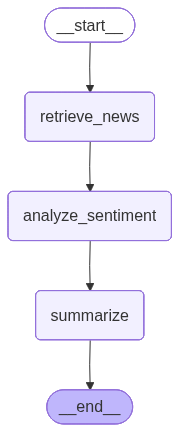

✅ Graph visualization displayed above!


In [20]:
try:
    # Get the graph visualization
    graph_image = app.get_graph().draw_mermaid_png()
    
    # Display in notebook
    display(Image(graph_image))
    print("✅ Graph visualization displayed above!")
    
except Exception as e:
    print(f"⚠️ Could not generate graph visualization: {e}")
    print("\nText representation of the graph:")
    print("┌─────────────────┐")
    print("│     START       │")
    print("└────────┬────────┘")
    print("         │")
    print("         ▼")
    print("┌─────────────────┐")
    print("│ retrieve_news   │")
    print("└────────┬────────┘")
    print("         │")
    print("         ▼")
    print("┌─────────────────┐")
    print("│analyze_sentiment│")
    print("└────────┬────────┘")
    print("         │")
    print("         ▼")
    print("┌─────────────────┐")
    print("│   summarize     │")
    print("└────────┬────────┘")
    print("         │")
    print("         ▼")
    print("┌─────────────────┐")
    print("│      END        │")
    print("└─────────────────┘")

## 8. Run the Agent!

Let's execute our news sentiment analysis workflow with sample parameters.

In [21]:
# Define input parameters
initial_state = {
    'topic': 'artificial intelligence',
    'location': 'California',
    'time_interval': 7,
    'news_articles': [],
    'sentiment_results': [],
    'messages': []
}

print("🚀 Running News Sentiment Analysis Agent...")
print(f"Topic: {initial_state['topic']}")
print(f"Location: {initial_state['location']}")
print(f"Time Range: Last {initial_state['time_interval']} days")
print("="*60)

# Execute the workflow
final_state = app.invoke(initial_state)

print("\n" + "="*60)
print("✅ Workflow completed successfully!")
print(f"Total messages in conversation: {len(final_state['messages'])}")

🚀 Running News Sentiment Analysis Agent...
Topic: artificial intelligence
Location: California
Time Range: Last 7 days

📰 Node 1: Retrieving news...
🔍 Fetching news about 'artificial intelligence' in California from last 7 days...
✅ Found 3 articles

🎭 Node 2: Analyzing sentiment...
  Article 1: POSITIVE (100.00%)
  Article 2: POSITIVE (99.80%)
  Article 3: NEGATIVE (93.20%)

📊 Node 3: Generating summary...

        📈 Sentiment Analysis Summary:
        Topic: artificial intelligence
        Location: California
        Time Period: Last 7 days
        Total Articles: 3
        Positive: 2 (66.7%)
        Negative: 1 (33.3%)

        📰 Articles with Sentiment:
        
        1. 😊 [POSITIVE] Artificial Intelligence Innovation Breakthrough in California
           🔗 https://example.com/news/artificial-intelligence-innovation-breakthrough
           📊 Confidence: 100.0%
        
        2. 😊 [POSITIVE] Major Artificial Intelligence Conference Held in California
           🔗 https://exam

In [22]:
final_state['messages']

[HumanMessage(content='Retrieved 3 articles about artificial intelligence', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Retrieved 3 articles about artificial intelligence', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Analyzed sentiment for 3 articles', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Retrieved 3 articles about artificial intelligence', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Retrieved 3 articles about artificial intelligence', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Analyzed sentiment for 3 articles', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='\n        📈 Sentiment Analysis Summary:\n        Topic: artificial intelligence\n        Location: California\n        Time Period: Last 7 days\n        Total Articles: 3\n        Positive: 2 (66.7%)\n        Negative: 1 (33.3%)\n\n        📰 Articles with Sentiment:\n        \n       

## 9. Visualize Results

Let's create some visualizations of the sentiment analysis results.

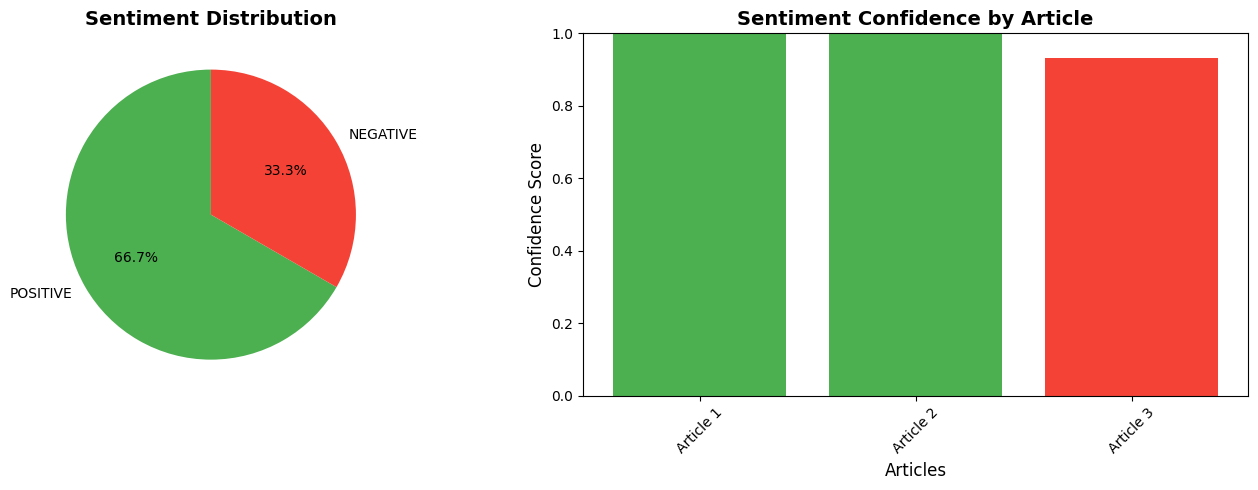


📊 Visualization complete!


In [13]:
import matplotlib.pyplot as plt
import numpy as np

results = final_state['sentiment_results']

if results:
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart of sentiment distribution
    sentiments = [r['sentiment'] for r in results]
    sentiment_counts = {}
    for s in sentiments:
        sentiment_counts[s] = sentiment_counts.get(s, 0) + 1
    
    colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}
    pie_colors = [colors.get(s, '#999') for s in sentiment_counts.keys()]
    
    axes[0].pie(
        sentiment_counts.values(),
        labels=[s.upper() for s in sentiment_counts.keys()],
        autopct='%1.1f%%',
        colors=pie_colors,
        startangle=90
    )
    axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
    
    # Bar chart of confidence scores
    articles = [f"Article {i+1}" for i in range(len(results))]
    confidences = [r['confidence'] for r in results]
    bar_colors = [colors.get(r['sentiment'], '#999') for r in results]
    
    axes[1].bar(articles, confidences, color=bar_colors)
    axes[1].set_xlabel('Articles', fontsize=12)
    axes[1].set_ylabel('Confidence Score', fontsize=12)
    axes[1].set_title('Sentiment Confidence by Article', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 1)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Visualization complete!")
else:
    print("No results to visualize")

## 10. Detailed Results Table

View all articles with their sentiment analysis:

In [ ]:
import pandas as pd

if results:
    # Create a cleaner dataframe with headlines and links
    display_data = []
    for r in results:
        display_data.append({
            'Headline': r['headline'],
            'Sentiment': r['sentiment'].upper(),
            'Confidence': f"{r['confidence']:.2%}",
            'Link': r['link'],
            'Date': r.get('date', 'Unknown')[:10] if r.get('date') != 'Unknown' else 'Unknown'
        })
    
    df = pd.DataFrame(display_data)
    df.index = df.index + 1
    df.index.name = '#'
    
    print("📋 Detailed Sentiment Analysis Results:\n")
    print(df.to_string())
    
    print("\n\n🔗 Clickable Links:")
    for i, r in enumerate(results, 1):
        print(f"{i}. {r['headline']}")
        print(f"   {r['link']}\n")
else:
    print("No results available")

📋 Detailed Sentiment Analysis Results:

                                                         article sentiment confidence                        date
#                                                                                                                
1  Artificial Intelligence Innovation Breakthrough in California  positive    100.00%  2025-10-28T19:36:38.123310
2    Major Artificial Intelligence Conference Held in California  positive     99.80%  2025-10-27T19:36:38.123310
3                Artificial Intelligence Market Faces Challenges  negative     93.20%  2025-10-26T19:36:38.123310


## 📰 Complete News Report with Links

Here's the final report with all headlines, sentiment analysis, and direct links to the articles:

In [ ]:
if results:
    print("="*80)
    print(f"📰 NEWS SENTIMENT ANALYSIS REPORT")
    print(f"Topic: {initial_state['topic'].upper()}")
    print(f"Location: {initial_state['location']}")
    print(f"Time Period: Last {initial_state['time_interval']} days")
    print("="*80)
    
    for i, article in enumerate(results, 1):
        sentiment_emoji = "😊 POSITIVE" if article['sentiment'] == 'positive' else "😟 NEGATIVE"
        
        print(f"\n📌 Article {i}:")
        print(f"   Headline: {article['headline']}")
        print(f"   Sentiment: {sentiment_emoji} (Confidence: {article['confidence']:.1%})")
        print(f"   🔗 Link: {article['link']}")
        print(f"   📅 Date: {article.get('date', 'Unknown')[:10] if article.get('date') != 'Unknown' else 'Unknown'}")
        print(f"   📰 Source: {article.get('source', 'Unknown')}")
        print(f"   Summary: {article.get('description', 'No description')[:100]}...")
    
    print("\n" + "="*80)
    positive_count = sum(1 for r in results if r['sentiment'] == 'positive')
    negative_count = sum(1 for r in results if r['sentiment'] == 'negative')
    print(f"📊 Overall Sentiment: {positive_count} Positive, {negative_count} Negative")
    print("="*80)
else:
    print("No results to display")

## 🎉 Congratulations!

You've successfully created a LangGraph workflow for news sentiment analysis!

### Key Concepts Learned:

1. **State Management**: Defined a `AgentState` TypedDict to share data between nodes
2. **Graph Nodes**: Created functions that process and transform state
3. **Graph Construction**: Built a workflow with `StateGraph` and connected nodes with edges
4. **Tools**: Integrated news retrieval and sentiment analysis tools
5. **Visualization**: Generated graph diagrams and result visualizations

### What's Next?

#### Run the Streamlit App
Open a terminal and run:
```bash
streamlit run news_sentiment_app.py
```

#### Enhancements You Can Try:

1. **Real News API**: Replace mock data with NewsAPI (get free key at https://newsapi.org/)
2. **Conditional Edges**: Add routing logic based on article count or sentiment
3. **Human-in-the-Loop**: Add approval nodes for human feedback
4. **Memory**: Persist conversation history across runs
5. **Multiple Models**: Compare different sentiment models
6. **Async Processing**: Use LangGraph's async features for parallel processing

### LangGraph Resources:

- Documentation: https://langchain-ai.github.io/langgraph/
- Examples: https://github.com/langchain-ai/langgraph/tree/main/examples
- Tutorials: https://python.langchain.com/docs/langgraph

---

## 🎓 Exercises for Students

Now that you understand this news sentiment analysis agent, try these challenges:

### Exercise 1: Add More Sentiment Categories
The current model only has POSITIVE/NEGATIVE. Try using a different model that supports more emotions:
```python
# Try this model instead:
sentiment_analyzer = pipeline("sentiment-analysis", model="j-hartmann/emotion-english-distilroberta-base")
```

### Exercise 2: Add a Filtering Node
Create a new node that filters out articles with low confidence scores (e.g., < 0.7).

### Exercise 3: Compare Multiple Topics
Modify the agent to analyze sentiment for multiple topics simultaneously and compare results.

### Exercise 4: Add Time-Series Analysis
Create a node that tracks sentiment changes over time for the same topic.

### Exercise 5: Use a Different Local Model
Try other Hugging Face models:
- `cardiffnlp/twitter-roberta-base-sentiment` (for social media text)
- `finiteautomata/bertweet-base-sentiment-analysis` (for tweets)
- Compare their performance!

### Exercise 6: Integrate Real News API
Sign up for a free API key at https://newsapi.org and replace the mock data with real news.

---

## 📚 Additional Resources

- **Hugging Face Models**: https://huggingface.co/models?pipeline_tag=sentiment-analysis
- **LangGraph Documentation**: https://docs.langchain.com/oss/python/langgraph/
- **Transformers Library**: https://huggingface.co/docs/transformers/
- **News API**: https://newsapi.org/docs

---

## 🔑 Key Takeaways

1. **Local AI is Powerful**: You don't always need cloud APIs
2. **LangGraph Simplifies Workflows**: Build complex agents with clear structure
3. **State Management**: Critical for multi-step processes
4. **Tool Integration**: Combine AI with traditional programming
5. **Visualization Helps**: Graph view makes debugging easier

---

---

## 🎬 Quick Demo - Try Different Topics

Here are some interesting topics you can try:

In [15]:
# Try different topics!
test_topics = [
    {"topic": "climate change", "location": "Europe", "days": 7},
    {"topic": "cryptocurrency", "location": "New York", "days": 3},
    {"topic": "space exploration", "location": "Texas", "days": 14},
    {"topic": "renewable energy", "location": "California", "days": 7},
]

print("🎯 Suggested topics to explore:\n")
for i, test in enumerate(test_topics, 1):
    print(f"{i}. Topic: {test['topic']:20} | Location: {test['location']:15} | Days: {test['days']}")

print("\n💡 To test a topic, modify the initial_state dictionary in cell 17 and re-run from there!")

🎯 Suggested topics to explore:

1. Topic: climate change       | Location: Europe          | Days: 7
2. Topic: cryptocurrency       | Location: New York        | Days: 3
3. Topic: space exploration    | Location: Texas           | Days: 14
4. Topic: renewable energy     | Location: California      | Days: 7

💡 To test a topic, modify the initial_state dictionary in cell 17 and re-run from there!
